In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


**DUAL ATTENTION VISSION TRANSFORMER MODEL (DaViT)**

In [1]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

# Define paths
data_dir = '/kaggle/input/maize-disease/Model'  # Replace with the actual path to your dataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transforms  # Apply validation transforms

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load the DaViT model
model = timm.create_model("hf_hub:timm/davit_base.msft_in1k", pretrained=True, num_classes=4)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

# Training function (without early stopping)
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Scheduler step
        scheduler.step()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# Save the trained model
torch.save(model.state_dict(), "davit_maize_leaf_model.pth")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/352M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


Epoch 1/30
----------
Training Loss: 0.2405 Acc: 0.9002
Validation Loss: 0.1942 Acc: 0.9218
Epoch 2/30
----------
Training Loss: 0.1426 Acc: 0.9450
Validation Loss: 0.1271 Acc: 0.9534
Epoch 3/30
----------
Training Loss: 0.1100 Acc: 0.9564
Validation Loss: 0.1667 Acc: 0.9433
Epoch 4/30
----------
Training Loss: 0.0711 Acc: 0.9730
Validation Loss: 0.1520 Acc: 0.9531
Epoch 5/30
----------
Training Loss: 0.0481 Acc: 0.9834
Validation Loss: 0.1696 Acc: 0.9511
Epoch 6/30
----------
Training Loss: 0.0251 Acc: 0.9904
Validation Loss: 0.1861 Acc: 0.9505
Epoch 7/30
----------
Training Loss: 0.0274 Acc: 0.9910
Validation Loss: 0.2057 Acc: 0.9306
Epoch 8/30
----------
Training Loss: 0.0188 Acc: 0.9943
Validation Loss: 0.2095 Acc: 0.9482
Epoch 9/30
----------
Training Loss: 0.0195 Acc: 0.9930
Validation Loss: 0.2216 Acc: 0.9488
Epoch 10/30
----------
Training Loss: 0.0155 Acc: 0.9950
Validation Loss: 0.2028 Acc: 0.9485
Epoch 11/30
----------
Training Loss: 0.0031 Acc: 0.9993
Validation Loss: 0.214

**CLASSIFICATION REPORT**

In [3]:
from sklearn.metrics import classification_report

def generate_classification_report(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Generate the classification report
    report = classification_report(all_labels, all_preds, target_names=val_loader.dataset.dataset.classes)
    print(report)

# Generate the classification report
generate_classification_report(model, val_loader)


              precision    recall  f1-score   support

     HEATHLY       1.00      1.00      1.00      1081
         MLN       1.00      0.99      1.00       796
       MSV_1       0.86      0.89      0.87       604
       MSV_2       0.88      0.86      0.87       588

    accuracy                           0.95      3069
   macro avg       0.94      0.94      0.94      3069
weighted avg       0.95      0.95      0.95      3069



**CONFUSSION MATRIX**

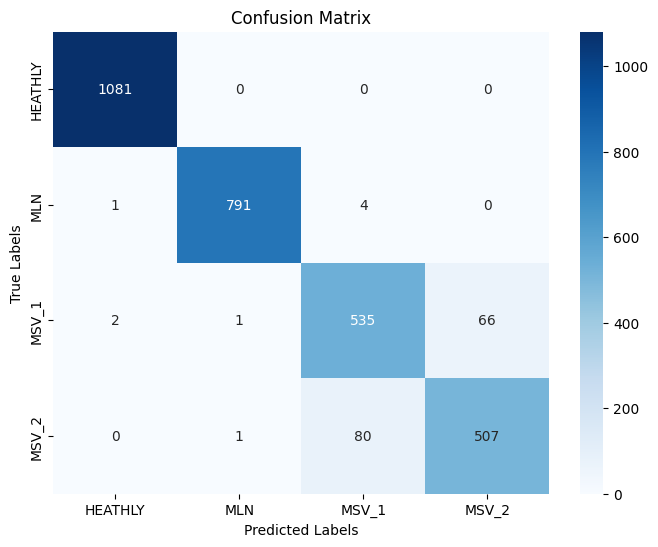

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Create the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_loader.dataset.dataset.classes, 
                yticklabels=val_loader.dataset.dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(model, val_loader)


In [7]:
import torch
# Save the model after training
torch.save(model.state_dict(), "/kaggle/working/davit_maize_leaf_model.pth")


NameError: name 'model' is not defined